In [ ]:
# !pip install scikit-optimize scikeras
# !pip uninstall tensorflow
# !pip install tensorflow==2.12.0
# !pip install keras==2.12.0
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1
# !pip install scikeras
# !pip install scikit-optimize

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
  Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires scikit-learn>=1.4.2, but you have scikit-learn 1.3.1 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import os
import numpy as np
import random

SEED = 42

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

set_seeds(seed=SEED)

In [ ]:
import pandas as pd
import numpy as np
from scipy.io import arff
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# file_path = '/content/drive/My Drive/SEE/rawData/kitchenham.arff'

# data, meta = arff.loadarff(file_path)
# df = pd.DataFrame(data)
# df.to_csv('/content/drive/My Drive/SEE/rawData/kitchenham.csv', index = False)

df = pd.read_csv('/content/drive/My Drive/SEE/rawData/kitchenham.csv')
print(df.head())
print(df.dtypes)
print(df.describe())

   id  Project  Client.code Project.type Actual.start.date  Actual.duration  \
0   1        1            1            A        12/10/1996              107   
1   2        2            1            D         6/16/1997              144   
2   3        3            1            D          3/1/1997              604   
3   4        4            1            P         6/23/1997              226   
4   5        5            1            D         1/20/1997              326   

   Actual.effort  Adjusted.function.points Estimated.completion.date  \
0            485                    101.65                 4/15/1997   
1            990                     57.12                 8/19/1997   
2          13635                   1010.88                 6/30/1998   
3           1576                     45.60                  3/6/1998   
4           3826                   1022.58                  1/1/1998   

   First.estimate First.estimate.method  
0             495                    EO  
1       

### Conversion to Numerical Data

### Encoding Categorical Features

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first', sparse_output=False)

columns_to_encode = ['Project.type', 'First.estimate.method']
encoded_array = encoder.fit_transform(df[columns_to_encode])

encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(columns_to_encode))
encoded_features = encoded_df.columns.tolist()
df_encoded = pd.concat([df.drop(columns_to_encode, axis=1), encoded_df], axis=1)

print(encoded_features)
print(df_encoded.head)
df = df_encoded

['Project.type_A', 'Project.type_C', 'Project.type_D', 'Project.type_P', 'Project.type_Pr', 'Project.type_U', 'First.estimate.method_C', 'First.estimate.method_CAE', 'First.estimate.method_D', 'First.estimate.method_EO', 'First.estimate.method_W']
<bound method NDFrame.head of       id  Project  Client.code Actual.start.date  Actual.duration  \
0      1        1            1        12/10/1996              107   
1      2        2            1         6/16/1997              144   
2      3        3            1          3/1/1997              604   
3      4        4            1         6/23/1997              226   
4      5        5            1         1/20/1997              326   
..   ...      ...          ...               ...              ...   
140  141      141            6         6/19/1995              253   
141  142      142            6         8/27/1997              405   
142  143      143            6          5/5/1997              241   
143  144      144            6  

### Sequential conversion and time indexing

In [ ]:
df['Actual.start.date'] = pd.to_datetime(df['Actual.start.date'], errors='coerce')
# df['Estimated.completion.date'] = pd.to_datetime(df['Estimated.completion.date'], errors='coerce')
df = df.drop(['Estimated.completion.date'], axis=1)

df = df.sort_values(['Actual.start.date'])
df = df.set_index(['Actual.start.date'])
print(df.index[:5])

DatetimeIndex(['1994-01-14', '1994-05-23', '1994-09-01', '1994-09-04',
               '1994-10-03'],
              dtype='datetime64[ns]', name='Actual.start.date', freq=None)


In [ ]:
print(df.head())
print(df.dtypes)
print(df.describe())

                    id  Project  Client.code  Actual.duration  Actual.effort  \
Actual.start.date                                                              
1994-01-14         112      112            2              392           4414   
1994-05-23         115      115            2              249           3189   
1994-09-01         102      102            2              946         113930   
1994-09-04         125      125            2              180            989   
1994-10-03          46       46            2              207           1532   

                   Adjusted.function.points  First.estimate  Project.type_A  \
Actual.start.date                                                             
1994-01-14                           401.00            4176             0.0   
1994-05-23                           403.00            3720             0.0   
1994-09-01                         18137.48           79870             0.0   
1994-09-04                           103.40 

### Missing Value

In [ ]:
df.replace("?", np.nan, inplace=True)

missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print("No missing values")
else:
    print("Have missing values")
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    numeric_columns = [col for col in numeric_columns if col != 'Actual.start.date']
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

No missing values


### Clip outliers

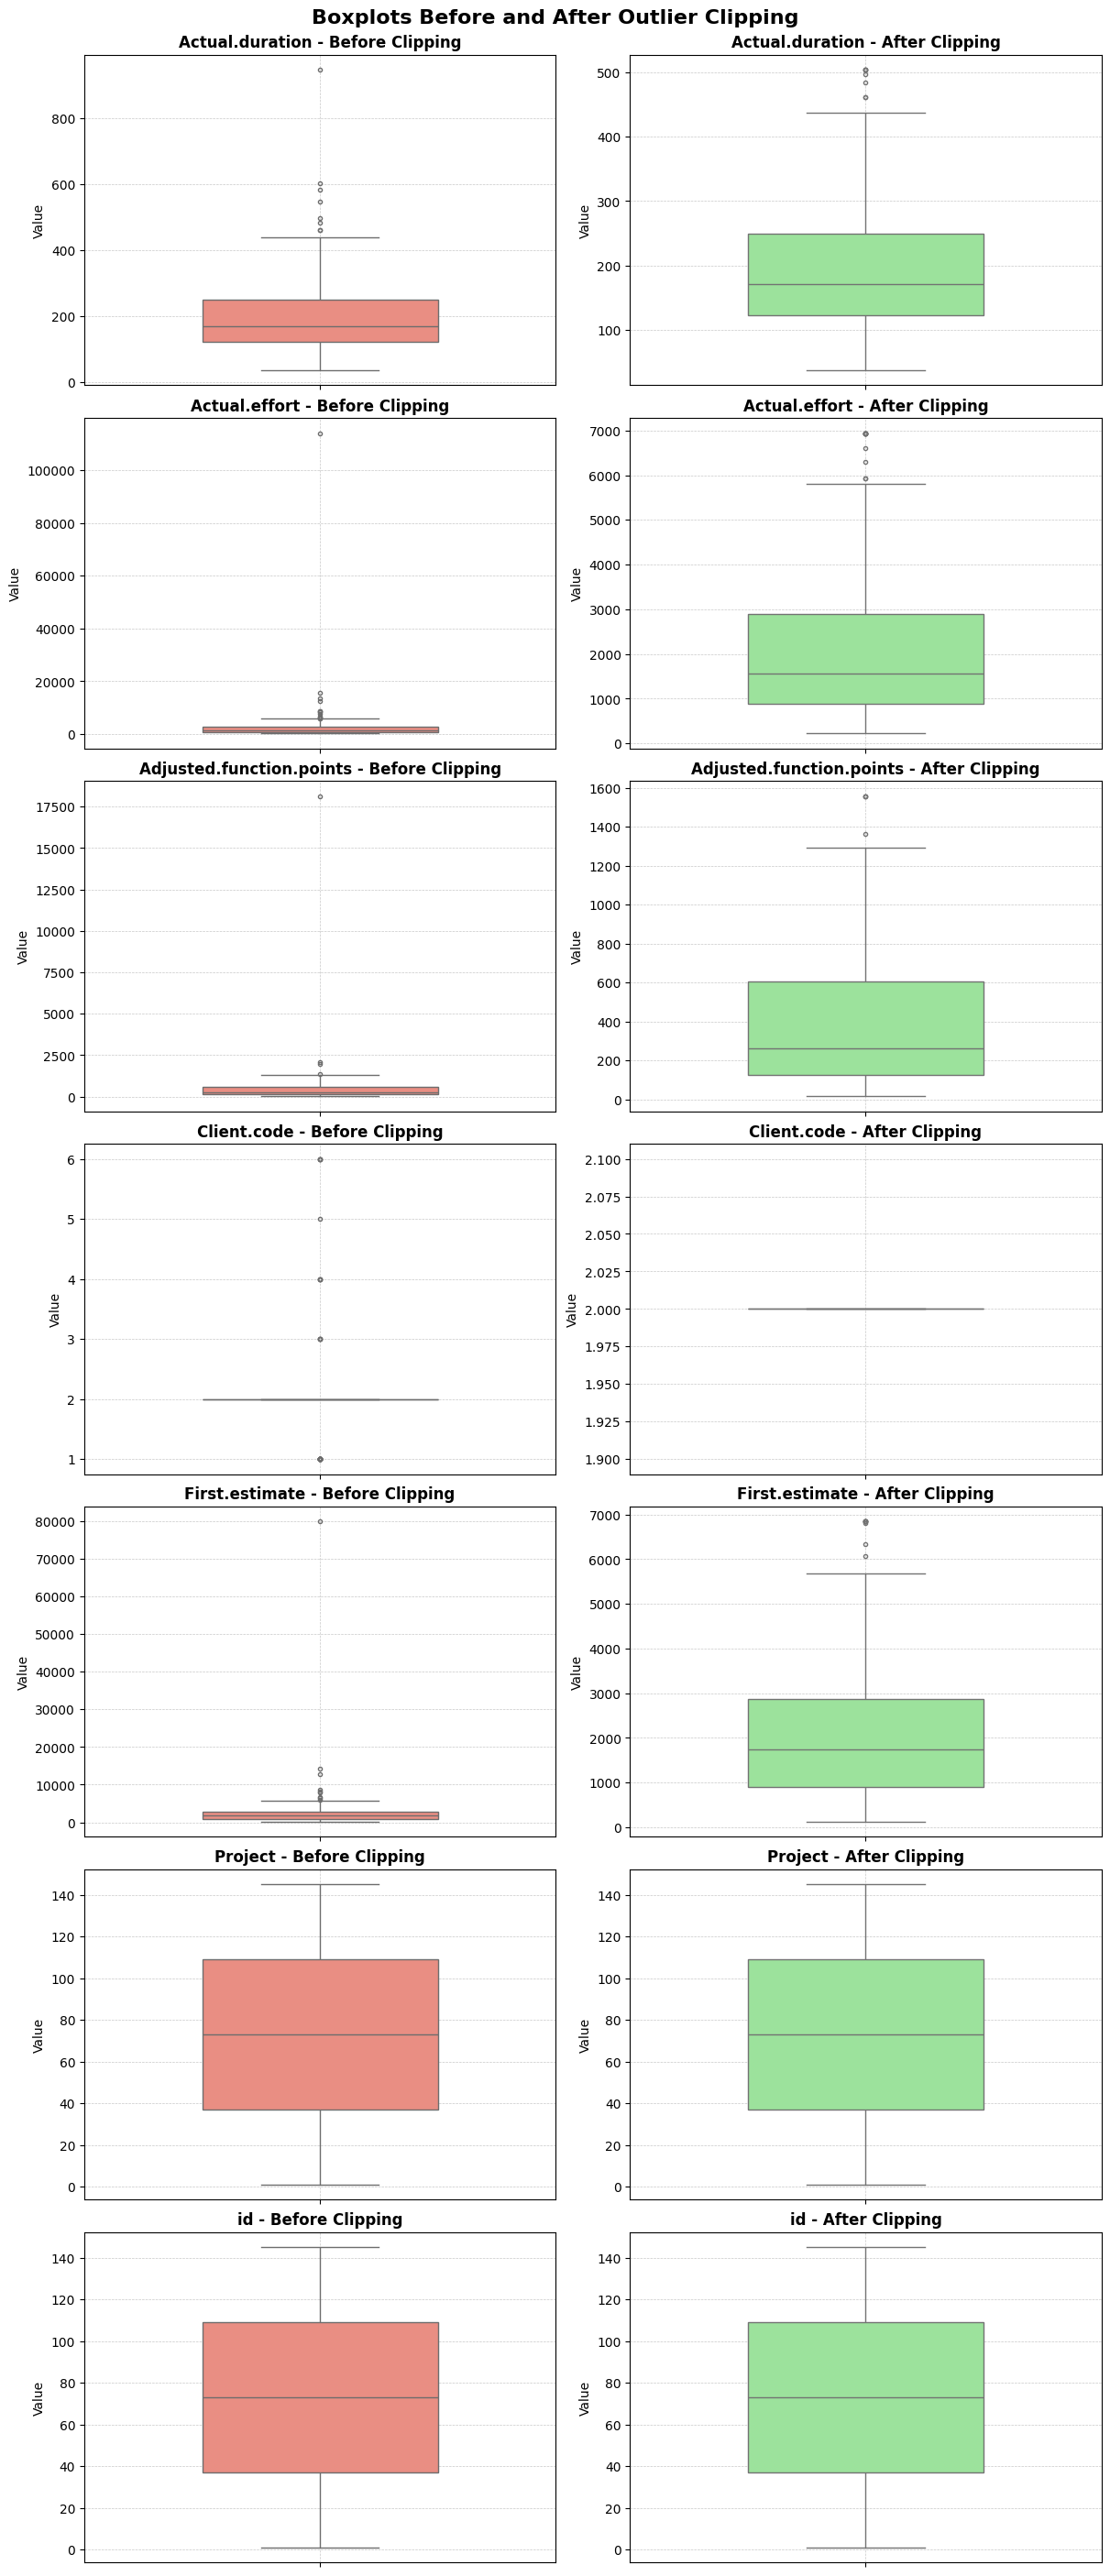

In [ ]:
def clip_outliers(df, whisker_coeff, encoded_features):
    df_clipped = df.copy()
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.difference(encoded_features)

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - whisker_coeff * IQR
        upper = Q3 + whisker_coeff * IQR

        df_clipped[col] = df[col].clip(lower, upper)

    return df_clipped

def plot_all_boxplots(original_df, clipped_df, encoded_features):
    numeric_cols = original_df.select_dtypes(include=['float64', 'int64']).columns.difference(encoded_features)
    num_cols = len(numeric_cols)

    fig, axes = plt.subplots(num_cols, 2, figsize=(12, 4 * num_cols), constrained_layout=True)

    for i, col in enumerate(numeric_cols):
        # Before clipping
        sns.boxplot(y=original_df[col], ax=axes[i][0], color='salmon', width=0.5, fliersize=3)
        axes[i][0].set_title(f'{col} - Before Clipping', fontsize=12, fontweight='bold')
        axes[i][0].set_ylabel('Value', fontsize=10)
        axes[i][0].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

        # After clipping
        sns.boxplot(y=clipped_df[col], ax=axes[i][1], color='lightgreen', width=0.5, fliersize=3)
        axes[i][1].set_title(f'{col} - After Clipping', fontsize=12, fontweight='bold')
        axes[i][1].set_ylabel('Value', fontsize=10)
        axes[i][1].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    fig.suptitle("Boxplots Before and After Outlier Clipping", fontsize=16, fontweight='bold')
    plt.show()

df_clipped = clip_outliers(df, whisker_coeff=2, encoded_features=encoded_features)
plot_all_boxplots(df, df_clipped, encoded_features=encoded_features)


<Axes: >

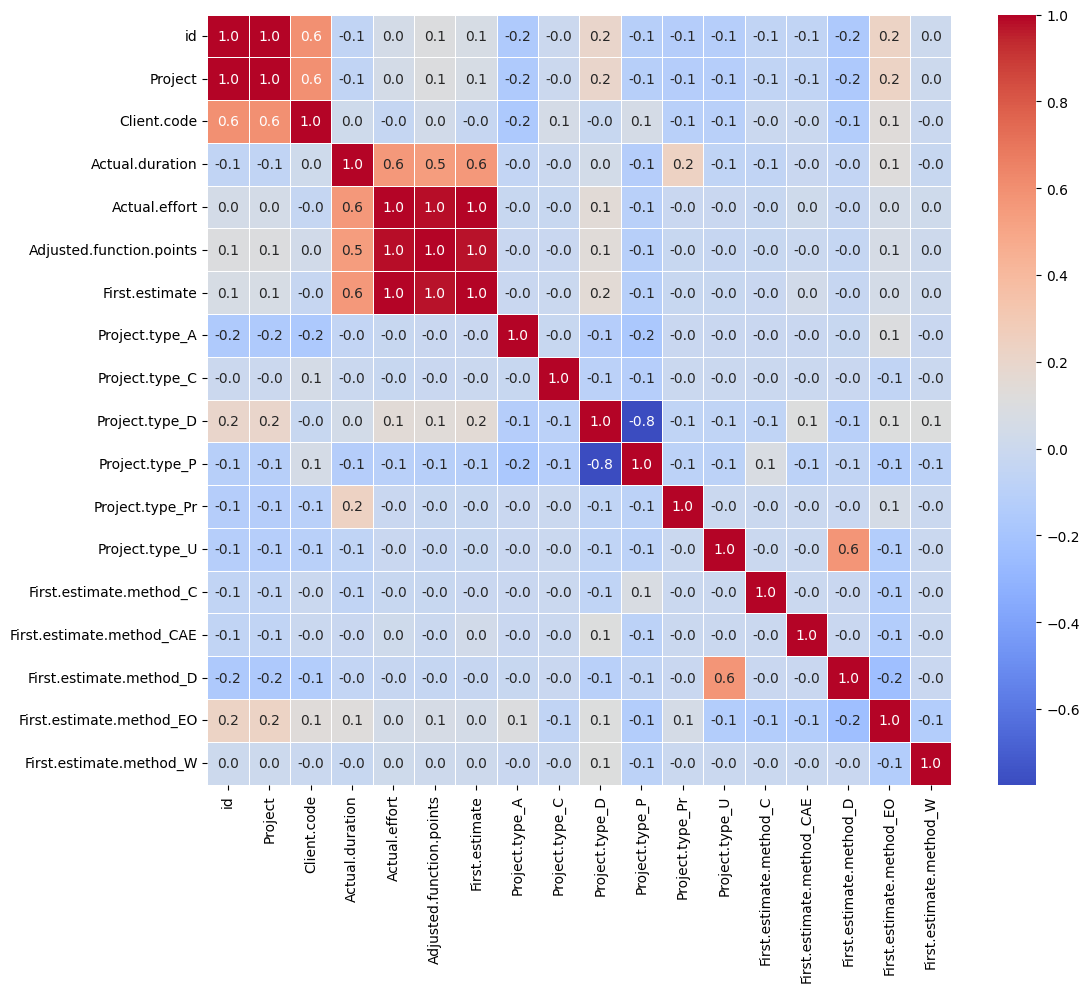

In [ ]:
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt='.1f', ax=ax, cmap='coolwarm')

In [ ]:
df = df_clipped.drop(['id','Project', 'First.estimate'], axis=1)
# df = df_clipped

### Split + Scaler

In [ ]:
X = df.drop(columns=['Actual.effort']).values
y = df['Actual.effort'].values.reshape(-1, 1)

# scaler_X = MinMaxScaler()
# scaler_y = MinMaxScaler()

# X_normalized = scaler_X.fit_transform(X)
# y_normalized = scaler_y.fit_transform(y)

# X_reshaped = X_normalized.reshape((X_normalized.shape[0], X_normalized.shape[1], 1))
# # X_reshaped = X_normalized.reshape((X_normalized.shape[0], 1, X_normalized.shape[1]))
# # X_reshaped = X_normalized

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Inverse

In [ ]:
def rescaled(true_values, predicted_values):
    true_rescaled = scaler_y.inverse_transform(true_values.reshape(-1, 1)).flatten()
    predicted_rescaled = scaler_y.inverse_transform(predicted_values.reshape(-1, 1)).flatten()

    return true_rescaled, predicted_rescaled

In [ ]:
def evaluate_metrics(true_values, predicted_values):
    true_values = np.array(true_values).flatten()
    predicted_values = np.array(predicted_values).flatten()

    mae = mean_absolute_error(true_values, predicted_values)
    mse = mean_squared_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, predicted_values)
    mre = np.absolute(true_values - predicted_values) / true_values
    mmre = np.mean(mre)
    mdmre = np.median(mre)
    p = mre[mre<0.25]
    pred = (p.size/mre.size) * 100

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'MMRE': mmre,
        'MdMRE': mdmre,
        'PRED(25)': pred
    }

### CNN

In [ ]:
from scikeras.wrappers import KerasRegressor
from keras.regularizers import l2
from skopt import BayesSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, LSTM, Attention, ReLU, Activation, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from skopt.space import Real, Integer, Categorical
import matplotlib.pyplot as plt
from keras.callbacks import Callback
from sklearn.model_selection import KFold

In [ ]:
def build_CNN(optimizer='adam', learning_rate=0.001):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        opt = SGD(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model

cnn_model = KerasRegressor(
    model=build_CNN,
    optimizer="adam",
    learning_rate=0.001,
    batch_size=32,
    epochs=20,
    verbose=0
)

cnn_search_space = {
    "optimizer": ['adam', 'rmsprop', 'sgd'],
    "learning_rate": (1e-4, 1e-1, 'log-uniform'),
    "batch_size": (1, 100),
    "epochs": (10, 50),
}

cv = KFold(n_splits=10, shuffle=True, random_state=42)

cnn_tuner = BayesSearchCV(
    estimator=cnn_model,
    search_spaces=cnn_search_space,
    n_iter=20,
    cv=cv,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

cnn_tuner.fit(X_train, y_train)

best_lstm_params = cnn_tuner.best_params_
print("Best Hyperparameters:")
for hp_name, hp_value in best_lstm_params.items():
    print(f"  {hp_name}: {hp_value}")

best_cnn_model = cnn_tuner.best_estimator_

y_cnn_pred = best_cnn_model.predict(X_test)

# Nếu y_lstm_pred có shape (samples, 1), thì không cần reshape
# Nếu có dạng (samples, timesteps, 1), cần lấy bước cuối
if len(y_cnn_pred.shape) == 3:
    y_cnn_pred = y_cnn_pred[:, -1, :]  # Lấy bước thời gian cuối cùng
    y_cnn_pred = y_cnn_pred.reshape(-1)

cnn_metrics = evaluate_metrics(y_test, y_cnn_pred)

for cnn_metric, value in cnn_metrics.items():
    print(f"{cnn_metric}: {value}")

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Hyperparameters:
  batch_size: 95
  epochs: 27
  learning_rate: 0.0015297005697785793
  optimizer: rmsprop
MAE: 0.14781995968319012
MSE: 0.04072967841177088
RMSE: 0.20181595182683373
R2: 0.596256929012997
MMRE: 5.679871751549585
MdMRE: 0.4267075654888494
PRED(25): 27.586206896551722


### LSTM

In [ ]:
def build_LSTM(units1=64, learning_rate=0.001, dropout_rate=0.2, regularization=0.001):
    model = Sequential()
    model.add(Input(shape=(X_reshaped.shape[1], X_reshaped.shape[2])))
    model.add(LSTM(units1, return_sequences=True, kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    # model.add(LSTM(units2, kernel_regularizer=l2(regularization)))
    # model.add(Dropout(dropout_rate))

    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    return model

lstm_model = KerasRegressor(
    build_fn=build_LSTM,
    verbose=0,
    units1=64,
    # units2=32,
    learning_rate=0.001,
    dropout_rate=0.2,
    regularization=0.001,
    batch_size=32,
    epochs=10
)

search_space = {
    'units1': Integer(10, 500),
    # 'units2': Integer(10, 200),
    'learning_rate': Real(1e-4, 1e-2, prior='log-uniform'),
    'dropout_rate': Real(0.1, 0.5),
    'regularization': Real(1e-5, 1e-2, prior='log-uniform'),
    'batch_size': Integer(200, 1000),
    'epochs': Integer(10, 50)
}

lstm_tuner = BayesSearchCV(
    estimator=lstm_model,
    search_spaces=search_space,
    cv=5,
    n_iter=20,
    scoring='neg_mean_squared_error',
    n_jobs=1,
    verbose=2,
    random_state=42
)

lstm_tuner.fit(X_train, y_train)

best_lstm_params = lstm_tuner.best_params_
print("Best Hyperparameters:")
for hp_name, hp_value in best_lstm_params.items():
    print(f"  {hp_name}: {hp_value}")

best_lstm_model = lstm_tuner.best_estimator_

y_lstm_pred = best_lstm_model.predict(X_test)

# Nếu y_lstm_pred có shape (samples, 1), thì không cần reshape
# Nếu có dạng (samples, timesteps, 1), cần lấy bước cuối
if len(y_lstm_pred.shape) == 3:
    y_lstm_pred = y_lstm_pred[:, -1, :]  # Lấy bước thời gian cuối cùng
    y_lstm_pred = y_lstm_pred.reshape(-1)

lstm_metrics = evaluate_metrics(y_test, y_lstm_pred)

for lstm_metric, value in lstm_metrics.items():
    print(f"{lstm_metric}: {value}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=528, dropout_rate=0.39109029727093003, epochs=47, learning_rate=0.0004281531928076346, regularization=0.0010243393225105074, units1=213; total time=   7.1s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=528, dropout_rate=0.39109029727093003, epochs=47, learning_rate=0.0004281531928076346, regularization=0.0010243393225105074, units1=213; total time=   7.9s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=528, dropout_rate=0.39109029727093003, epochs=47, learning_rate=0.0004281531928076346, regularization=0.0010243393225105074, units1=213; total time=   6.0s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=528, dropout_rate=0.39109029727093003, epochs=47, learning_rate=0.0004281531928076346, regularization=0.0010243393225105074, units1=213; total time=   7.5s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=528, dropout_rate=0.39109029727093003, epochs=47, learning_rate=0.0004281531928076346, regularization=0.0010243393225105074, units1=213; total time=   5.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=870, dropout_rate=0.4533261109523449, epochs=22, learning_rate=0.007988179462781242, regularization=0.0039118639884156686, units1=41; total time=   7.0s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=870, dropout_rate=0.4533261109523449, epochs=22, learning_rate=0.007988179462781242, regularization=0.0039118639884156686, units1=41; total time=   4.4s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=870, dropout_rate=0.4533261109523449, epochs=22, learning_rate=0.007988179462781242, regularization=0.0039118639884156686, units1=41; total time=   4.3s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=870, dropout_rate=0.4533261109523449, epochs=22, learning_rate=0.007988179462781242, regularization=0.0039118639884156686, units1=41; total time=   5.3s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=870, dropout_rate=0.4533261109523449, epochs=22, learning_rate=0.007988179462781242, regularization=0.0039118639884156686, units1=41; total time=   4.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=556, dropout_rate=0.4674890086677509, epochs=14, learning_rate=0.0007356404539935663, regularization=3.663241571989203e-05, units1=232; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=556, dropout_rate=0.4674890086677509, epochs=14, learning_rate=0.0007356404539935663, regularization=3.663241571989203e-05, units1=232; total time=   5.7s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=556, dropout_rate=0.4674890086677509, epochs=14, learning_rate=0.0007356404539935663, regularization=3.663241571989203e-05, units1=232; total time=   3.5s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=556, dropout_rate=0.4674890086677509, epochs=14, learning_rate=0.0007356404539935663, regularization=3.663241571989203e-05, units1=232; total time=   3.6s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=556, dropout_rate=0.4674890086677509, epochs=14, learning_rate=0.0007356404539935663, regularization=3.663241571989203e-05, units1=232; total time=   6.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=850, dropout_rate=0.16874862455862427, epochs=34, learning_rate=0.0040320839179989465, regularization=0.0003708147357379244, units1=57; total time=   5.3s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=850, dropout_rate=0.16874862455862427, epochs=34, learning_rate=0.0040320839179989465, regularization=0.0003708147357379244, units1=57; total time=   6.7s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=850, dropout_rate=0.16874862455862427, epochs=34, learning_rate=0.0040320839179989465, regularization=0.0003708147357379244, units1=57; total time=   4.9s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=850, dropout_rate=0.16874862455862427, epochs=34, learning_rate=0.0040320839179989465, regularization=0.0003708147357379244, units1=57; total time=   4.8s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=850, dropout_rate=0.16874862455862427, epochs=34, learning_rate=0.0040320839179989465, regularization=0.0003708147357379244, units1=57; total time=   5.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=840, dropout_rate=0.27521167457636936, epochs=31, learning_rate=0.002700390206185342, regularization=0.005147024286785697, units1=361; total time=   5.0s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=840, dropout_rate=0.27521167457636936, epochs=31, learning_rate=0.002700390206185342, regularization=0.005147024286785697, units1=361; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=840, dropout_rate=0.27521167457636936, epochs=31, learning_rate=0.002700390206185342, regularization=0.005147024286785697, units1=361; total time=   6.6s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=840, dropout_rate=0.27521167457636936, epochs=31, learning_rate=0.002700390206185342, regularization=0.005147024286785697, units1=361; total time=   7.7s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=840, dropout_rate=0.27521167457636936, epochs=31, learning_rate=0.002700390206185342, regularization=0.005147024286785697, units1=361; total time=   5.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=787, dropout_rate=0.4757478950411087, epochs=17, learning_rate=0.00023814999872958598, regularization=0.0025206334448741735, units1=193; total time=   4.2s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=787, dropout_rate=0.4757478950411087, epochs=17, learning_rate=0.00023814999872958598, regularization=0.0025206334448741735, units1=193; total time=   5.3s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=787, dropout_rate=0.4757478950411087, epochs=17, learning_rate=0.00023814999872958598, regularization=0.0025206334448741735, units1=193; total time=   4.0s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=787, dropout_rate=0.4757478950411087, epochs=17, learning_rate=0.00023814999872958598, regularization=0.0025206334448741735, units1=193; total time=   4.0s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=787, dropout_rate=0.4757478950411087, epochs=17, learning_rate=0.00023814999872958598, regularization=0.0025206334448741735, units1=193; total time=   5.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=694, dropout_rate=0.41014575153115307, epochs=24, learning_rate=0.005605967693796125, regularization=0.0005995964127756074, units1=301; total time=   4.4s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=694, dropout_rate=0.41014575153115307, epochs=24, learning_rate=0.005605967693796125, regularization=0.0005995964127756074, units1=301; total time=   6.3s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=694, dropout_rate=0.41014575153115307, epochs=24, learning_rate=0.005605967693796125, regularization=0.0005995964127756074, units1=301; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=694, dropout_rate=0.41014575153115307, epochs=24, learning_rate=0.005605967693796125, regularization=0.0005995964127756074, units1=301; total time=   5.3s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=694, dropout_rate=0.41014575153115307, epochs=24, learning_rate=0.005605967693796125, regularization=0.0005995964127756074, units1=301; total time=   6.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=635, dropout_rate=0.46800369057492663, epochs=30, learning_rate=0.004734922490673388, regularization=9.379505596171679e-05, units1=35; total time=   4.8s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=635, dropout_rate=0.46800369057492663, epochs=30, learning_rate=0.004734922490673388, regularization=9.379505596171679e-05, units1=35; total time=   6.2s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=635, dropout_rate=0.46800369057492663, epochs=30, learning_rate=0.004734922490673388, regularization=9.379505596171679e-05, units1=35; total time=   4.6s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=635, dropout_rate=0.46800369057492663, epochs=30, learning_rate=0.004734922490673388, regularization=9.379505596171679e-05, units1=35; total time=   4.4s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=635, dropout_rate=0.46800369057492663, epochs=30, learning_rate=0.004734922490673388, regularization=9.379505596171679e-05, units1=35; total time=   5.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=964, dropout_rate=0.3802485778485464, epochs=45, learning_rate=0.0006786442521779151, regularization=0.0001390574606467376, units1=114; total time=   5.2s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=964, dropout_rate=0.3802485778485464, epochs=45, learning_rate=0.0006786442521779151, regularization=0.0001390574606467376, units1=114; total time=   9.3s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=964, dropout_rate=0.3802485778485464, epochs=45, learning_rate=0.0006786442521779151, regularization=0.0001390574606467376, units1=114; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=964, dropout_rate=0.3802485778485464, epochs=45, learning_rate=0.0006786442521779151, regularization=0.0001390574606467376, units1=114; total time=   7.3s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=964, dropout_rate=0.3802485778485464, epochs=45, learning_rate=0.0006786442521779151, regularization=0.0001390574606467376, units1=114; total time=   5.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=203, dropout_rate=0.42713200786550065, epochs=40, learning_rate=0.0003229300915669146, regularization=0.000544493887456265, units1=145; total time=   7.0s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=203, dropout_rate=0.42713200786550065, epochs=40, learning_rate=0.0003229300915669146, regularization=0.000544493887456265, units1=145; total time=   5.3s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=203, dropout_rate=0.42713200786550065, epochs=40, learning_rate=0.0003229300915669146, regularization=0.000544493887456265, units1=145; total time=   6.8s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=203, dropout_rate=0.42713200786550065, epochs=40, learning_rate=0.0003229300915669146, regularization=0.000544493887456265, units1=145; total time=   5.1s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=203, dropout_rate=0.42713200786550065, epochs=40, learning_rate=0.0003229300915669146, regularization=0.000544493887456265, units1=145; total time=   5.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=200, dropout_rate=0.5, epochs=50, learning_rate=0.01, regularization=1e-05, units1=500; total time=   9.2s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=200, dropout_rate=0.5, epochs=50, learning_rate=0.01, regularization=1e-05, units1=500; total time=   9.0s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=200, dropout_rate=0.5, epochs=50, learning_rate=0.01, regularization=1e-05, units1=500; total time=   9.1s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=200, dropout_rate=0.5, epochs=50, learning_rate=0.01, regularization=1e-05, units1=500; total time=   8.1s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=200, dropout_rate=0.5, epochs=50, learning_rate=0.01, regularization=1e-05, units1=500; total time=   9.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=200, dropout_rate=0.5, epochs=50, learning_rate=0.003954057953303973, regularization=1e-05, units1=500; total time=   9.1s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=200, dropout_rate=0.5, epochs=50, learning_rate=0.003954057953303973, regularization=1e-05, units1=500; total time=   7.8s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=200, dropout_rate=0.5, epochs=50, learning_rate=0.003954057953303973, regularization=1e-05, units1=500; total time=   8.4s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=200, dropout_rate=0.5, epochs=50, learning_rate=0.003954057953303973, regularization=1e-05, units1=500; total time=  11.3s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=200, dropout_rate=0.5, epochs=50, learning_rate=0.003954057953303973, regularization=1e-05, units1=500; total time=   9.6s
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=211, dropout_rate=0.38256746423238985, epochs=10, learning_rate=0.0039273703904911875, regularization=0.00011798567773791905, units1=500; total time=   4.3s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=211, dropout_rate=0.38256746423238985, epochs=10, learning_rate=0.0039273703904911875, regularization=0.00011798567773791905, units1=500; total time=   4.2s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=211, dropout_rate=0.38256746423238985, epochs=10, learning_rate=0.0039273703904911875, regularization=0.00011798567773791905, units1=500; total time=   5.3s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=211, dropout_rate=0.38256746423238985, epochs=10, learning_rate=0.0039273703904911875, regularization=0.00011798567773791905, units1=500; total time=   4.0s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=211, dropout_rate=0.38256746423238985, epochs=10, learning_rate=0.0039273703904911875, regularization=0.00011798567773791905, units1=500; total time=   4.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=482, dropout_rate=0.14395777096252582, epochs=35, learning_rate=0.006695249058039399, regularization=3.372506939467105e-05, units1=500; total time=   9.4s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=482, dropout_rate=0.14395777096252582, epochs=35, learning_rate=0.006695249058039399, regularization=3.372506939467105e-05, units1=500; total time=   8.1s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=482, dropout_rate=0.14395777096252582, epochs=35, learning_rate=0.006695249058039399, regularization=3.372506939467105e-05, units1=500; total time=   6.8s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=482, dropout_rate=0.14395777096252582, epochs=35, learning_rate=0.006695249058039399, regularization=3.372506939467105e-05, units1=500; total time=   7.5s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=482, dropout_rate=0.14395777096252582, epochs=35, learning_rate=0.006695249058039399, regularization=3.372506939467105e-05, units1=500; total time=   6.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=200, dropout_rate=0.1, epochs=49, learning_rate=0.005098557935573677, regularization=1e-05, units1=223; total time=   7.2s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=200, dropout_rate=0.1, epochs=49, learning_rate=0.005098557935573677, regularization=1e-05, units1=223; total time=   5.8s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=200, dropout_rate=0.1, epochs=49, learning_rate=0.005098557935573677, regularization=1e-05, units1=223; total time=   7.4s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=200, dropout_rate=0.1, epochs=49, learning_rate=0.005098557935573677, regularization=1e-05, units1=223; total time=   9.8s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=200, dropout_rate=0.1, epochs=49, learning_rate=0.005098557935573677, regularization=1e-05, units1=223; total time=   7.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=200, dropout_rate=0.5, epochs=37, learning_rate=0.005335216162737157, regularization=0.01, units1=319; total time=   7.1s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=200, dropout_rate=0.5, epochs=37, learning_rate=0.005335216162737157, regularization=0.01, units1=319; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=200, dropout_rate=0.5, epochs=37, learning_rate=0.005335216162737157, regularization=0.01, units1=319; total time=   7.1s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=200, dropout_rate=0.5, epochs=37, learning_rate=0.005335216162737157, regularization=0.01, units1=319; total time=   5.6s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=200, dropout_rate=0.5, epochs=37, learning_rate=0.005335216162737157, regularization=0.01, units1=319; total time=   6.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=1000, dropout_rate=0.1, epochs=50, learning_rate=0.0001, regularization=1e-05, units1=500; total time=  10.6s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=1000, dropout_rate=0.1, epochs=50, learning_rate=0.0001, regularization=1e-05, units1=500; total time=   8.1s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=1000, dropout_rate=0.1, epochs=50, learning_rate=0.0001, regularization=1e-05, units1=500; total time=   9.1s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=1000, dropout_rate=0.1, epochs=50, learning_rate=0.0001, regularization=1e-05, units1=500; total time=   8.4s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=1000, dropout_rate=0.1, epochs=50, learning_rate=0.0001, regularization=1e-05, units1=500; total time=   8.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=1000, dropout_rate=0.5, epochs=50, learning_rate=0.01, regularization=1e-05, units1=500; total time=   8.9s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=1000, dropout_rate=0.5, epochs=50, learning_rate=0.01, regularization=1e-05, units1=500; total time=   8.3s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=1000, dropout_rate=0.5, epochs=50, learning_rate=0.01, regularization=1e-05, units1=500; total time=  10.5s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=1000, dropout_rate=0.5, epochs=50, learning_rate=0.01, regularization=1e-05, units1=500; total time=   9.9s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=1000, dropout_rate=0.5, epochs=50, learning_rate=0.01, regularization=1e-05, units1=500; total time=   9.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=1000, dropout_rate=0.1, epochs=50, learning_rate=0.01, regularization=1e-05, units1=10; total time=   5.9s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=1000, dropout_rate=0.1, epochs=50, learning_rate=0.01, regularization=1e-05, units1=10; total time=   7.2s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=1000, dropout_rate=0.1, epochs=50, learning_rate=0.01, regularization=1e-05, units1=10; total time=   5.6s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=1000, dropout_rate=0.1, epochs=50, learning_rate=0.01, regularization=1e-05, units1=10; total time=   7.1s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=1000, dropout_rate=0.1, epochs=50, learning_rate=0.01, regularization=1e-05, units1=10; total time=   5.5s
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=918, dropout_rate=0.357271285736104, epochs=50, learning_rate=0.0027188738595847945, regularization=3.60278326352292e-05, units1=10; total time=   8.8s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=918, dropout_rate=0.357271285736104, epochs=50, learning_rate=0.0027188738595847945, regularization=3.60278326352292e-05, units1=10; total time=   6.8s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=918, dropout_rate=0.357271285736104, epochs=50, learning_rate=0.0027188738595847945, regularization=3.60278326352292e-05, units1=10; total time=   6.7s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=918, dropout_rate=0.357271285736104, epochs=50, learning_rate=0.0027188738595847945, regularization=3.60278326352292e-05, units1=10; total time=   6.0s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=918, dropout_rate=0.357271285736104, epochs=50, learning_rate=0.0027188738595847945, regularization=3.60278326352292e-05, units1=10; total time=   6.7s


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Best Hyperparameters:
  batch_size: 200
  dropout_rate: 0.5
  epochs: 50
  learning_rate: 0.003954057953303973
  regularization: 1e-05
  units1: 500
MAE: 0.1640631283177774
MSE: 0.04815678642591124
RMSE: 0.2194465457142382
R2: 0.5226338729243782
MMRE: 6.470461109301991
MdMRE: 0.4808287161099739
PRED(25): 24.137931034482758


In [ ]:
y_test_rescaled, y_lstm_pred_rescaled = rescaled(y_test, y_lstm_pred)

lstm_metrics = evaluate_metrics(y_test_rescaled, y_lstm_pred_rescaled)

for lstm_metric, value in lstm_metrics.items():
    print(f"{lstm_metric}: {value}")

MAE: 2258.7768460787256
MSE: 8548790.161099043
RMSE: 2923.831418036793
R2: 0.853213305662031
MMRE: 0.721544874738647
MdMRE: 0.2687989156619756
PRED(25): 46.15384615384615


### MLP

In [ ]:
!pip install scikeras
!pip install scikit-optimize

  Using cached keras-3.9.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached keras-3.9.2-py3-none-any.whl (1.3 MB)
Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires keras<2.13,>=2.12.0, but you have keras 3.9.2 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.12.0 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
tensorflow-decision-forests 1.11.0 require

ERROR: Operation cancelled by user
^C


In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
def build_mlp(hp):
    model = Sequential([
        Dense(hp.Int('neurons1', min_value=32, max_value=256, step=32), activation=hp.Choice('activation', values=['relu', 'tanh'])),
        Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.05)),
        Dense(hp.Int('neurons2', min_value=16, max_value=128, step=16), activation=hp.Choice('activation', values=['relu', 'tanh'])),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')), loss='mse', metrics=['mean_absolute_error'])
    return model

tuner = BayesianOptimization(
    build_mlp,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='mlp_tuning',
    seed=SEED
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, verbose=1)

best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_hp = best_trial.hyperparameters
# best_hp = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters
print(f"Best Trial ID: {best_trial.trial_id}")
print("Best Hyperparameters:")
for hp_name, hp_value in best_hp.values.items():
    print(f"  {hp_name}: {hp_value}")

best_model = tuner.get_best_models(num_models=1)[0]

y_pred = best_model.predict(X_test)
metrics = evaluate_metrics(y_test, y_pred)

for metric, value in metrics.items():
    print(f"{metric}: {value}")

Reloading Tuner from keras_tuner_dir/mlp_tuning/tuner0.json
Best Trial ID: 22
Best Hyperparameters:
  neurons1: 256
  activation: relu
  dropout_rate: 0.30000000000000004
  neurons2: 32
  learning_rate: 0.00112157425708504
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
MAE: 0.055442390020101574
MSE: 0.006528306442033531
RMSE: 0.08079793587730773
R2: 0.9025642022849203
MMRE: 0.9336959091537685
MdMRE: 0.19290336113165896
PRED(25): 61.53846153846154


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
y_test_rescaled, y_pred_rescaled = rescaled(y_test, y_pred)

metrics = evaluate_metrics(y_test_rescaled, y_pred_rescaled)

for metric, value in metrics.items():
    print(f"{metric}: {value}")

MAE: 1634.5942828838638
MSE: 5674617.8417999055
RMSE: 2382.1456382429487
R2: 0.9025641782132617
MMRE: 0.37951210596215634
MdMRE: 0.18543177920708212
PRED(25): 61.53846153846154


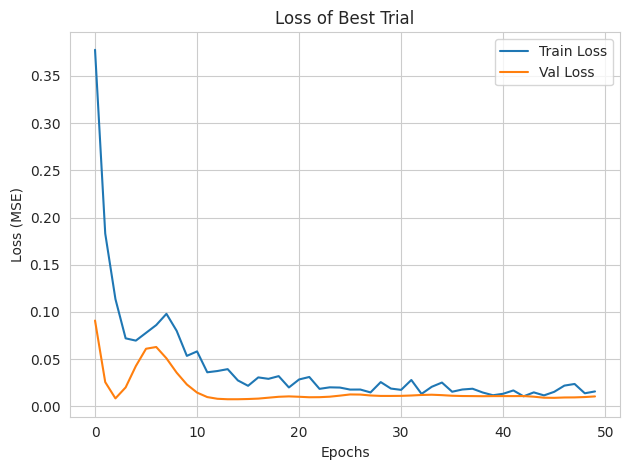

In [ ]:
model = tuner.hypermodel.build(best_hp)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=0)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Loss of Best Trial')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### RBFN

### BiLSTM

### RNN